# Проверка гипотез по увеличению выручки в интернет-магазине и оценка результатов A/B теста

# Описание проекта
Вместе с отделом маркетинга крупного интернет-магазина мы подготовили список из 9 гипотез для увеличения выручки.
В рамках исследовательского проекта приоритизируем гипотезы по фреймворкам ICE и RICE, построим графики кумулятивной выручки, среднего чека, конверсии по группам, а затем посчитаем статистическую значимость различий конверсий и средних чеков по сырым и очищенным данным. Запустим A/B-тест и проанализируем результаты исследования.


## Загрузка данных и подготовка к анализу

In [78]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import seaborn as sns
import math as mth
from IPython.display import display

In [2]:
#чтение данных и сохранение в переменные
try:
    hypothesis = pd.read_csv('_.csv')
except: 
    hypothesis = pd.read_csv('_.csv')
    
try:
    orders = pd.read_csv('_.csv')
except:
    orders = pd.read_csv('_.csv')
    
try:
    visitors = pd.read_csv('_.csv')
except:
    visitors = pd.read_csv('_.csv')

### Предобработка датасета hypothesis

In [3]:
display(hypothesis)
hypothesis.info()
#проверка на наличие пропусков
hypothesis.isna().sum()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

In [4]:
#проверка на наличие дубликатов
hypothesis.duplicated().sum()

0

Данные целостные, типы данных корректны, пропусков и дубликатов нет. Для стилистического удобства и избежания потенциальных ошибок при проведении исследования, считаем целесообразным привести название столбцов к строчному написанию.

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()

### Предобработка датасета orders

In [6]:
display(orders.head())
orders.info()
#проверка на наличие пропусков
orders.isna().sum()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [7]:
#проверка на наличие дубликатов
orders.duplicated().sum()

0

Пропуски и дубликаты в датасете orders отсутствуют. Для удобства анализа приведем названия двух столбцов к написанию в "змеином" регистре. Так же необходимо изменить тип данных в колонке с датами заказов.

In [8]:
orders.columns = (orders.columns.str.replace('Id', '_id')).str.lower()

In [9]:
orders['date'] = pd.to_datetime(orders['date'])

In [10]:
display(orders.head())
orders.info()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Датафрейм готов к анализу.

### Предобработка датасета visitors

In [11]:
display(visitors.head())
visitors.info()
#проверка на наличие пропусков
visitors.isna().sum()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


date        0
group       0
visitors    0
dtype: int64

In [12]:
#проверка на наличие дубликатов
visitors.duplicated().sum()

0

In [13]:
visitors['date'] = pd.to_datetime(visitors['date'])

Данные в датафрейме без пропусков и дубликатов, столбец с датами приведен к правильному типу данных. 

### Определение параметров групп для тестирования

In [88]:
#определение дат начала и окончания теста
print('Дата начала тестирования -', orders['date'].min())
print('Дата окончания теста -', orders['date'].max())

Дата начала тестирования - 2019-08-01 00:00:00
Дата окончания теста - 2019-08-31 00:00:00


In [56]:
print('Количество групп в А/В тесте - ', len(orders['group'].unique()))

Количество групп в А/В тесте -  2


In [70]:
#определение размера групп для тестирования
grp = orders['group'].value_counts().sort_values(key=lambda x: x, ascending=True)
grp

A    468
B    548
Name: group, dtype: int64

In [84]:
#процентная разбивка учасников тестирования по группам
total = (orders['group'] == 'A').sum() + (orders['group'] == 'B').sum()
percent_A = (orders['group'] == 'A').sum() / total * 100
percent_B = (orders['group'] == 'B').sum() / total * 100
print('Процентное соотношение участников группы A от общего количества: {:.2f}%'.format(percent_A))
print('Процентное соотношение участников группы B от общего количества: {:.2f}%'.format(percent_B))

Процентное соотношение участников группы A от общего количества: 46.06%
Процентное соотношение участников группы B от общего количества: 53.94%


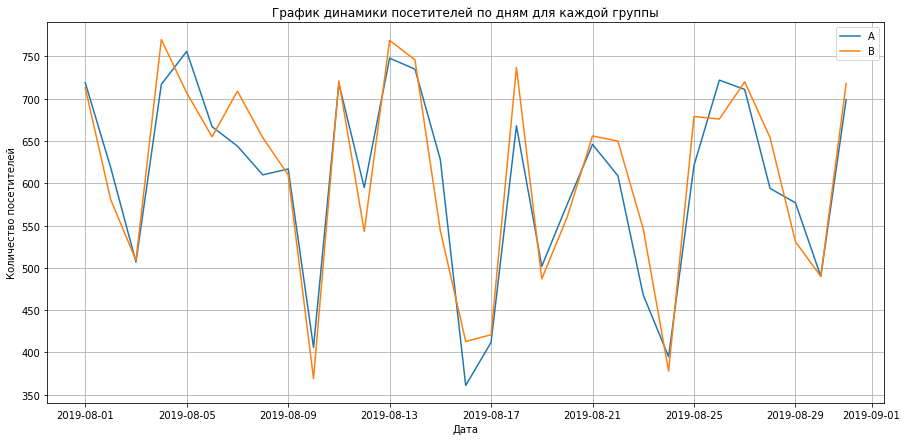

In [123]:
# определение динамики посетителей по дням для каждой группы
daily_visitors = visitors.groupby(['date', 'group'])['visitors'].sum()
daily_visitors = daily_visitors.reset_index()
# Построение графиков динамики посетителей для каждой группы
plt.figure(figsize=(15,7))
for group in ['A', 'B']:
    group_data = daily_visitors.query(f"group == '{group}'")
    plt.plot(group_data['date'], group_data['visitors'], label=group)
plt.grid()
plt.title('График динамики посетителей по дням для каждой группы')
plt.xlabel('Дата')
plt.ylabel('Количество посетителей')
plt.legend();

In [120]:
display(daily_visitors.head(10))

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,619
3,2019-08-02,B,581
4,2019-08-03,A,507
5,2019-08-03,B,509
6,2019-08-04,A,717
7,2019-08-04,B,770
8,2019-08-05,A,756
9,2019-08-05,B,707


###  Вывод по разделу

После знакомства с полученым датасетом, были произведены необходимые операции для проведения последующего анализа. Данные были проанализированы на наличие пропусков и дубликатов - их нет. Были изменены типы данных в столбцах с датами и временем. Названия столбцов были приведены к единому стандарту - строчное написание в "змеином" регистре. 

В результате мы имеем чистые и подготовленные к анализу данные. 

Участники теста разбиты на 2 группы. В группу А попали - 46.06% и в группу B - 53.94% пользователей. В целом, распределение равномерное. Дата начала проведения теста - 01.08.2019, дата промежуточного итога 31.08.2019. Количество посетителей в обеих группах равноценно и не повлияет на результаты теста.

## Приоритизация гипотез

В нашем распоряжении подготовленный отделом маркетинга файл с 9 гипотезами, для которых оценены значения Reach, Impact, Confidence и Efforts. Применим к этим гипотезам фреймворки ICE и RICE.

Фреймворк ICE - (impact х confidence) /efforts («(влияние * уверенность) / усилия »), учитывает перемноженные  
Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта; на Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; и разделенные на Efforts — сколько стоит протестировать эту гипотезу.

Фреймворк RICE - добавляет в числитель Reach — скольких пользователей затронет изменение, которое вы хотите внести. Итого (reach х impact х confidence) / efforts

In [124]:
#добавим пару стилистических украшений проекта. Увеличим ширину колонки для читабельности гипотез. А так же сократим отображение дробных частей числа до сотых, этого вполне достаточно для анализа показателей.
pd.set_option("max_colwidth", 400)
pd.set_option("display.float_format", "{:.2f}".format)

In [15]:
# применение фреймворка ICE
hypothesis['ice'] = (hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [16]:
# применение фреймворка RICE
hypothesis['rice'] = (hypothesis.reach * hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


In [17]:
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts,ice,rice
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20


Пятерка приоритетных гипотез по методу ICE:
* 8 - Запустить акцию, дающую скидку на товар в день рождения
* 0	- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* 6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	
* 2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

Пятерка приоритетных гипотез по методу RICE:
* 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* 2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* 0	- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* 6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
* 8 - Запустить акцию, дающую скидку на товар в день рождения

Как видно, топовые гипотезы не меняются от выбранного метода приоритизации, но существенно менятся их позиция. Например, занявшее 1 место по результату метода ICE гипотеза с индесом - 8, замыкает пятерку гипотез отобранных методом RICE. Такую разницу можно объяснить различием в параметре Reach - показывающем, скольких пользователей коснется предлагаемое изменение. Соотвтетсвенно при выборе гипотез для тестирования важно учитывать этот параметр. На наш взгляд, дальнейшего изучения заслуживают гипотезы 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок и 2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа. Поскольку имеют потенциальные возможности охватить большое количество пользователей магазина.

## Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в датафреймах orders и visitors. Проанализируем полученные результаты и начнем с проверки есть ли пользователи, попавшие в обе группы тестирования.

In [18]:
duplicated_users = np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(), orders.query('group == "B"')['visitor_id'].unique())
duplicated_users.size

58

Мы обнаружили 58 пользователей попавших в обе группы, что на наш взгляд может внести искажения в результаты теста, поэтому считаем целесообразным исключить таких пользователей из тестирования.

In [19]:
orders = orders[~orders['visitor_id'].isin(duplicated_users)]

### График кумулятивной выручки по группам

In [20]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                                    .agg({'date' : 'max', 
                                          'group' : 'max', 
                                          'transaction_id' : 'nunique', 
                                          'visitor_id' : 'nunique', 
                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                       .agg({'date' : 'max', 
                                             'group' : 'max', 
                                             'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(6)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
5,2019-08-03,B,54,53,288850,1803


In [131]:
#проверка корректности создания датафрейма, определение дат начала и окончания теста
print('Дата начала тестирования -', cumulativeData['date'].min())
print('Дата окончания теста -', cumulativeData['date'].max())

Дата начала тестирования - 2019-08-01 00:00:00
Дата окончания теста - 2019-08-31 00:00:00


Даты в созданном датафрейме совпадают с датами во входных исходных данных теста.

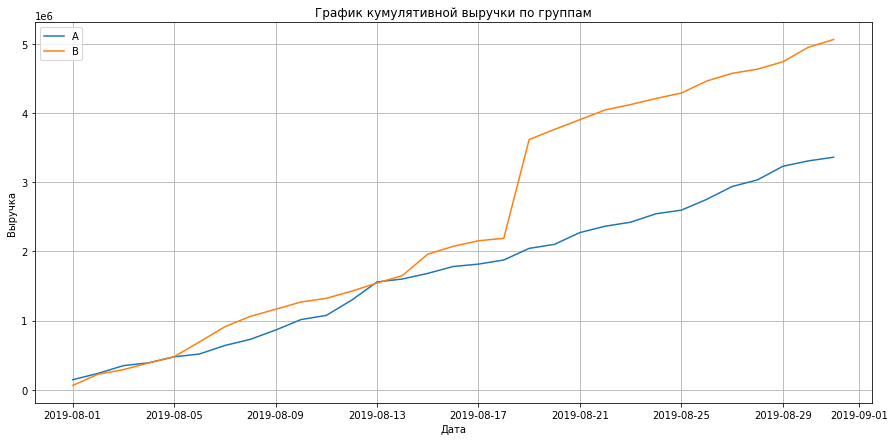

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,7))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.grid()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

Выручка стабильно растет в обеих группах. Группа B вырывается вперед с 5 августа. 19 августа происходит резкий скачок в выручке, что может быть связано либо с резким ростом числа заказов в этот день, либо с крайне высоким чеком. Проверим оба варианта. 

In [22]:
#проанализируем количество заказов в районе "выброса"
cumulativeRevenueB.query(' "2019-08-17" <= date <= "2019-08-21" ')

,date,revenue,orders
33,2019-08-17,2155542,320
35,2019-08-18,2190865,327
37,2019-08-19,3620785,348
39,2019-08-20,3768059,368
41,2019-08-21,3908406,380


In [23]:
orders.query('date == "2019-08-19"').sort_values(by='revenue', ascending=False).head(6)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A
461,2683113224,154576532,2019-08-19,26550,B
368,3268879337,2536252163,2019-08-19,20026,B


Количество заказов растет стабильно, без выбросов. Проблема в огромном чеке от 19 августа, многократно превышающем средние значения покупок в тот день и вносящем существенные искажения в результаты теста. 

### График кумулятивного среднего чека по группам

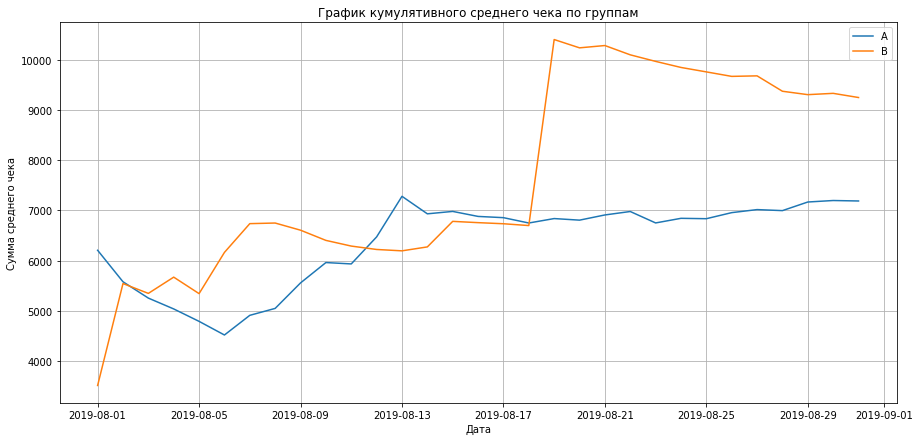

In [24]:
plt.figure(figsize=(15,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.grid()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.legend();

Как мы выяснили в анализе предыдущего графика, 19 августа был произведен огромный разовый заказ, оказавший такое влияние на поведение и данной метрики. А в целом, после скачкообразного роста, средний чек группы B стабильно снижался. Средний чек группы A стабилизировался к середние месяца и в дальнейшем незначительно колеблется в районе отметки 7000, с небольшой тенденцией к росту в конце месяца.

### График относительного изменения кумулятивного среднего чека группы B к группе A

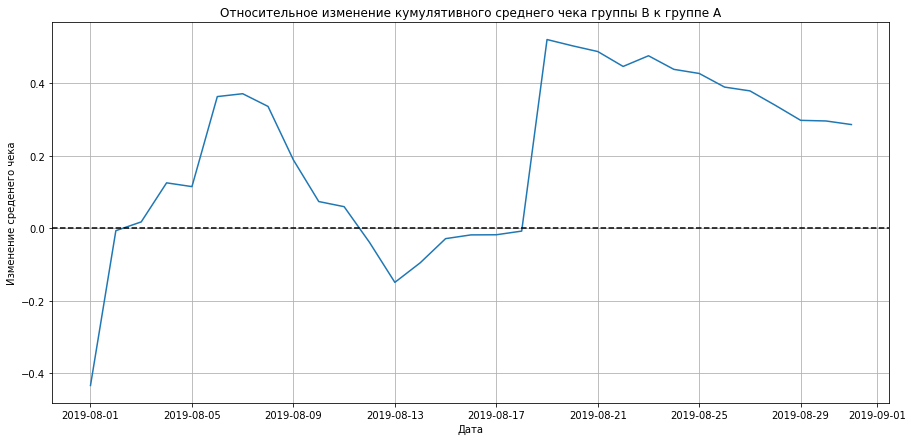

In [25]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе А')
plt.xlabel('Дата')
plt.ylabel('Изменение среденего чека')
plt.axhline(y=0, color='black', linestyle='--');

Очередной график подтверждает нашу находку о влиянии аномального заказа с индексом 425, на все результаты тестирования. Группа B была впереди по среднему чеку практически все время, но после скачка связанного с аномальным заказом средний чек постепенно снижался.

### График кумулятивного среднего количества заказов на посетителя по группам

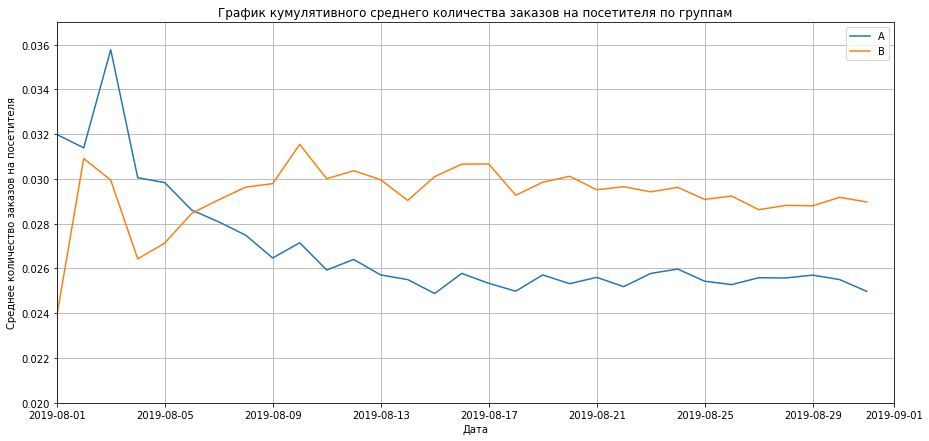

In [26]:
cumulativeData['avg'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['avg'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['avg'], label='B')
plt.grid()
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.02, 0.037]);

Среднее количество заказов на посетителя - стабильно лучше в группе B уже с 6 дня тестирования. Хотя на старте, группа А демонстировала неплохие показатели. Можно отметить, что с 10 дня обе группы более менее стабилизировались и держатся на одном уровне с незначительными колебаниями.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

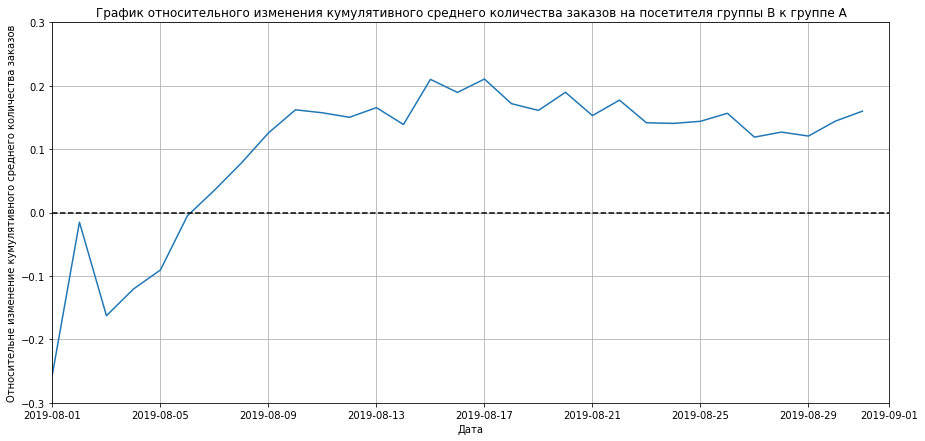

In [27]:
mergedCumulativeAvg = cumulativeDataA[['date','avg']].merge(cumulativeDataB[['date','avg']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,7))
plt.plot(mergedCumulativeAvg['date'], mergedCumulativeAvg['avgB']/mergedCumulativeAvg['avgA']-1)
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.3, 0.3])
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительне изменение кумулятивного среднего количества заказов');

График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A демонстрирует установившееся после первой трети теста превосходство группы B над группой А по данному параметру. Разрыв стабилизировался и держится на стабильном уровне. 

### Точечный график количества заказов по пользователям

In [ ]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['user_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

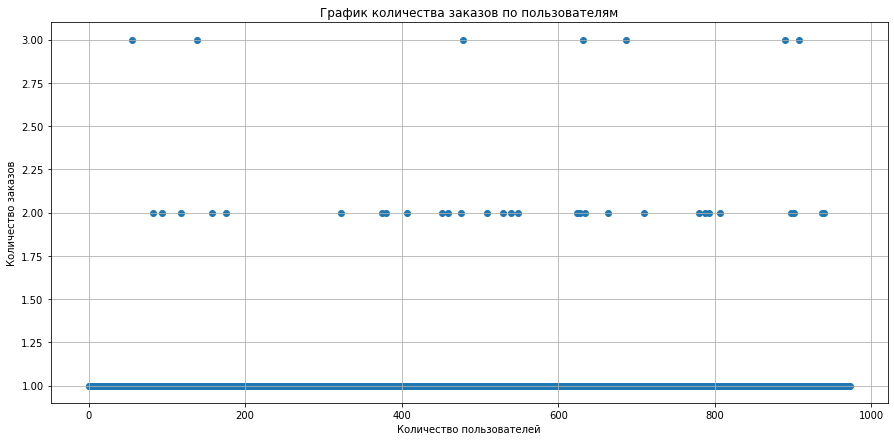

In [29]:
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(15,7))
plt.grid()
plt.title('График количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.scatter(x_values, ordersByUsers['orders']);

Большинство пользователей сайта соврешают 1 заказ, небольшое количество пользователей совершило 2 и всего 7 человек совершило 3 заказа за месяц тестирования.

### 95-й и 99-й перцентили количества заказов на пользователя

In [30]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


95% пользователей совершают 1 заказ и 99% пользователей совершают не более 2. 
Таким образом, пользователей совершающих более 2 покупок можно признать аномалией. 

Или просто редкими и ценными клиентами, с которыми стоит работать точечно в ручном режиме?

### Точечный график стоимостей заказов

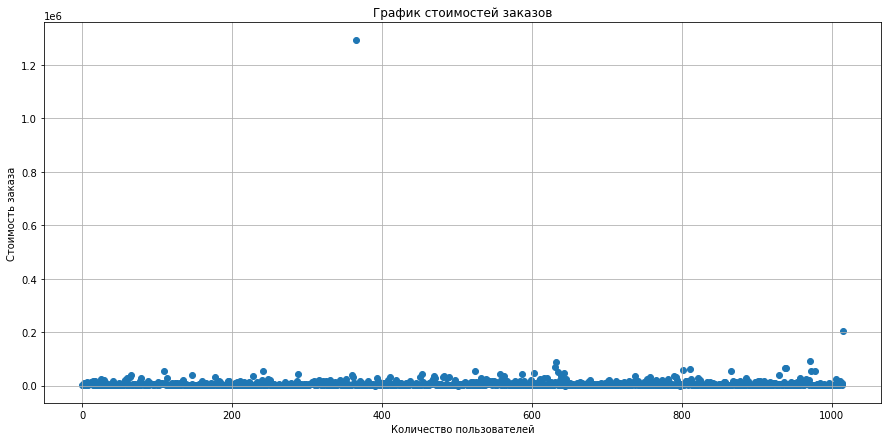

In [31]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,7))
plt.title('График стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказа')
plt.grid()
plt.scatter(x_values, orders['revenue']);

Два выброса делают график малоинформативным. Определим 95 и 99 перцентили, для выявления пороговой суммы аномального заказа, после чего построим исправленный график.

### 95-й и 99-й перцентили стоимости заказов

In [32]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


95% пользователей совершают заказы в пределах суммы 26785
99% заказов укладываются в сумму 53904, данную сумму можно принять за границу аномальных заказов. 

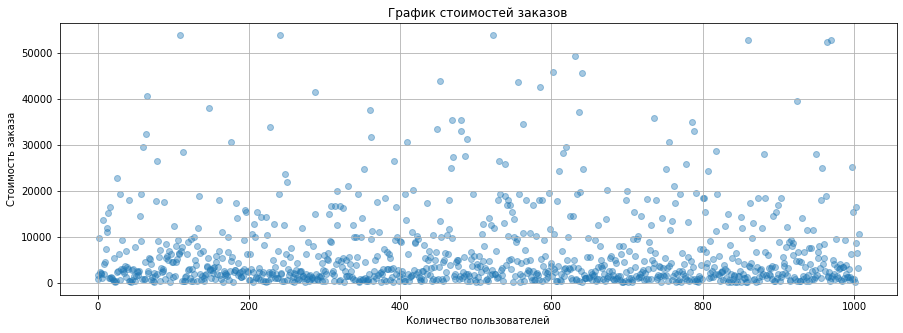

In [33]:
regular_orders = orders[orders['revenue']<=54000]['revenue']
xr_values = pd.Series(range(0,len(regular_orders)))
plt.figure(figsize=(15,5))
plt.title('График стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказа')
plt.grid()
plt.scatter(xr_values, regular_orders, alpha=0.4);

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [34]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [35]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['user_id', 'orders']

In [36]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Нулевая гипотеза H0 - статистически значимых различий в среднем количестве заказов на посетителя между группами нет.

Альтернативная гипотеза Н1 - статистически значимые различия есть.

In [37]:
#Применим статистический критерий Манна-Уитни к полученным выборкам
display('alpha = 0.05')
display('p-value = {0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
display('Относительное отличие среднего числа заказов на посетителя группы B = {0:.3f}'.format(sampleB.mean()/sampleA.mean()-1)) 

'alpha = 0.05'

'p-value = 0.011'

'Относительное отличие среднего числа заказов на посетителя группы B = 0.160'

По итогам проверки p-value = 0.011, что меньше принятых пороговых 0.05, а это означает, что гипотезу H0 - статистически значимых различий в среднем количестве заказов на посетителя между группами нет, придется отвергнуть, поскольку между ними есть статистчески значимые отличия. 

Группа B опережает группу А на 16%.  

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Для рассчета статистической значимости различий в среднем чеке между группами, передадим критерию mannwhitneyu() данные о выручке с заказов (пороговое значение 5%). И найдём относительные различия в среднем чеке между группами.

Нулевая гипотеза H0 - статистически значимых различий в среднем чеке между группами нет.

Альтернативная гипотеза Н1 - статистически значимые различия есть.

In [38]:
#Применим статистический критерий Манна-Уитни к полученным выборкам
display('alpha = 0.05')
display('p-value = {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
display('Относительное различие среднего чека группы B к группе A = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

'alpha = 0.05'

'p-value = 0.829'

'Относительное различие среднего чека группы B к группе A = 0.287'

p-value существенно больше порогового значения 5%, значит по "сырым" данным существенного отличия между средними чеками групп нет, нет причин отвергнуть нулевую гипотезу. При этом средний чек группы B выше, чем у группы А почти на 29%!

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Ранее мы приняли за аномальные значения пользователей с заказами > 2 и средним чеком выше 53904.

In [39]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['user_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [40]:
display(abnormalUsers.head())
display(len(abnormalUsers))

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64

16

В раздел "аномальных" попали 16 пользователей. Проведем повторный анализ без их участия.

In [41]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
                                       name='orders')],axis=0) 

Нулевая гипотеза H0 - статистически значимых различий в среднем количестве заказов на посетителя между группами нет.

Альтернативная гипотеза Н1 - статистически значимые различия есть.

In [42]:
#Применим статистический критерий Манна-Уитни к полученным выборкам
print('alpha =',0.05)
print('p-value = {0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print('Относительное отличие среднего числа заказов на посетителя группы B = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha = 0.05
p-value = 0.007
Относительное отличие среднего числа заказов на посетителя группы B = 0.189


По итогам проверки p-value = 0.007, что существенно меньше принятых пороговых 0.05, а это означает, что гипотезу H0 - статистически значимых различий в среднем количестве заказов на посетителя между группами нет, по прежнему придется отвергнуть, поскольку между ними есть статистчески значимые отличия.

Группа B по прежнему опережает группу А, по "очищенным" данным уже на на 18.9% (по "сырым" было 16%).

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза H0 - статистически значимых различий в среднем чеке между группами нет.

Альтернативная гипотеза Н1 - статистически значимые различия есть.

In [43]:
print('alpha =',0.05)
print('p-value = {0:.3f}'.format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'], alternative = 'two-sided')[1]))

print('Относительный показатель В и А = {0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

alpha = 0.05
p-value = 0.788
Относительный показатель В и А = -0.032


"Очищенные" данные помогли разгадать эту загадку, повисшую в воздухе после выводов в пункте 3.11. 
p-value и в данном случае существенно больше порогового значения 5%, а это значит, что и по "очищенным" данным существенного отличия между средними чеками групп нет, нет причин отвергнуть нулевую гипотезу. 
При этом средний чек группы B по очищенным данным стал ниже, чем у группы А на 3%. Таковым оказалось влияние аномальных чеков на результаты теста.

# Общие выводы по исследованию

Вместе с отделом маркетинга крупного интернет-магазина мы подготовили список из 9 гипотез для увеличения выручки. В рамках исследовательского проекта, была проведена приоретизация гипотез, затем был запущен A/B-тест и проанализированы его результаты. В качестве входных данных в нашем распоряжении было 3 датасета, с маркетинговыми гипотезами, с данными о заказах пользователей и с данными о посещаемости нашего сайта.

Над датасетами были произведены необходимые операции для проведения последующего анализа. Данные были проанализированы на наличие пропусков и дубликатов - их не было. Были изменены типы данных в столбцах с датами и временем. Названия столбцов были приведены к единому стандарту - строчное написание в "змеином" регистре.
В результате мы получили чистые и подготовленные к анализу данные.

Участники теста были разбиты на 2 группы. В группу А попали - 46.06% и в группу B - 53.94% пользователей. В целом, распределение равномерное. Дата начала проведения теста - 01.08.2019, дата промежуточного итога 31.08.2019. Количество посетителей в обеих группах равноценно и не повлияло на результаты теста. Перед началом теста датафрейм был так же проанализирован на кросспользователей. Мы обнаружили 58 пользователей попавших в обе группы тестирования, что на наш взгляд могло внести искажения в результаты, поэтому для чистоты тестирования, мы посчитали возможным исключить таких пользователей из участников теста.

При анализе данных полученных в рамках теста были построены графики:
* кумулятивной выручки по группам 
* кумулятивного среднего чека по группам
* относительного изменения кумулятивного среднего чека группы B к группе A
* кумулятивного среднего количества заказов на посетителя по группам
* относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
* точечный график количества заказов по пользователям
* точечный график стоимостей заказов

Что позволило выявить нам несколько аномальных транзакций. Один из самых ярких примеров - заказ с индексом 425 совершенный 19.08.2019, сумма которого составила 1294500, что многократно выше среднего чека в тесте и существенно исказило показатели некоторых исследуемых графиков.

Кроме того, были определены 95-й и 99-й перцентили количества заказов на пользователя и 95-й и 99-й перцентили стоимости заказов, что позволило определить нам рамки нормального поведение пользователей. Выяснили, что пользователь совершает не более 2 заказов и средняя сумма чека не превышает 54000. 

Далее были проанализированы: 
* Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным
* Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным
* Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным
* Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

По результатам этого анализа мы выяснили, что:
* Существует существенное отличие в среднем количестве заказов на посетителя между группами, как по "сырым", так и по "очищенным" данным. 
* Средний чек группы B показывал существенное превышение над группой А, но до момента очистки данных от аномальных значений. Без них можно констатировать, что средние чеки в двух группах примерно равны

Проанализировав всю имеющуюся информацию, мы останавливаем тест и фиксируем победу группы B. 
Гипотеза хорошо сработала в части увеличения количества заказов, но при этом демонстирует неудовлетворительные результаты в  аспекте увеличения среднего чека пользователя. Работа над повышением данного показателя, это уже детальная работа отдела маркетинга. Показатели стабильны и нет смысла продолжать тестирование данной гипотезы. 